In [1]:
%load_ext autoreload
%autoreload 1
%autosave 60

Autosaving every 60 seconds


In [2]:
import sys
import pandas as pd
import numpy as np
import importlib
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import seaborn as sb
from scipy import stats
from sklearn.decomposition import PCA
import scanpy
from anndata import AnnData
import umap
import anndata
import requests
import json

In [3]:
sys.path.append("/u/davidm/Documents/Memoire/Scripts/RNA-seq/python/")

In [4]:
import RNAseq
importlib.reload(RNAseq)

<module 'RNAseq' from '/u/davidm/Documents/Memoire/Scripts/RNA-seq/python/RNAseq.py'>

In [5]:
cell_line = "EV"
project = "sc-MCF7+MDAMB231-pmig-GRHL2_DSP1090"

### Plotting parameters

In [6]:
%matplotlib inline
plt.rcParams['figure.dpi'] = 110
plt.rcParams['font.family'] = 'DeJavu Serif'

### Raw CB frequency

In [7]:
y = pd.read_table(f"/home/arion/davidm/Data/datasets/private/RNA-seq/sc/{project}/quant/alevin/human/assembly__GRCh38-hg38/annotation__gencode/gencode_34/trimmed-reads-cutadapt/pc-decoys-k17-1.4.0/forceCells-7000-noWh/raw/{cell_line}/alevin/raw_cb_frequency.txt", header=None)[1]

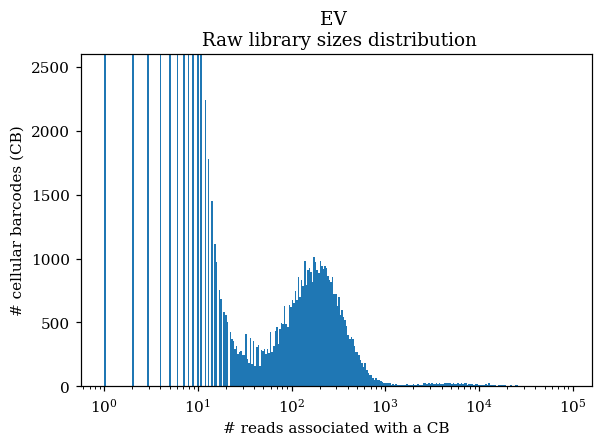

In [8]:
plt.title(f"{cell_line} \n Raw library sizes distribution")
plt.ylim(0,2600);
plt.xlabel("# reads associated with a CB")
plt.ylabel("# cellular barcodes (CB)")
RNAseq.plot_loghist(y, bins=300)

In [7]:
x = pd.read_table(f"/home/arion/davidm/Data/datasets/private/RNA-seq/sc/{project}/quant/alevin/human/assembly__GRCh38-hg38/annotation__gencode/gencode_34/trimmed-reads-cutadapt/pc-decoys-k17-1.4.0/forceCells-7000-noWh/raw/{cell_line}/alevin/featureDump.txt")

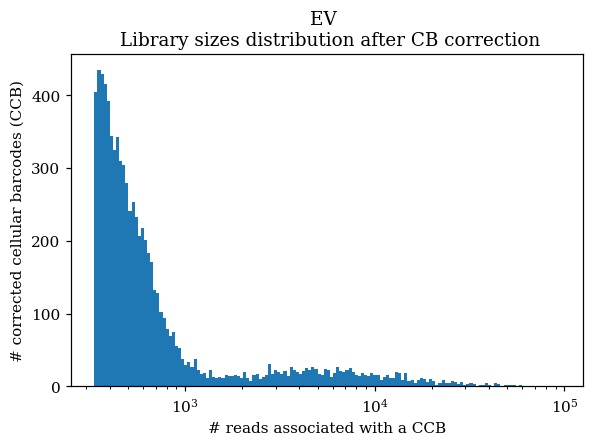

In [10]:
plt.title(f"{cell_line} \n Library sizes distribution after CB correction")
plt.xlabel("# reads associated with a CCB")
plt.ylabel("# corrected cellular barcodes (CCB)")
RNAseq.plot_loghist(x["CorrectedReads"], bins=150)

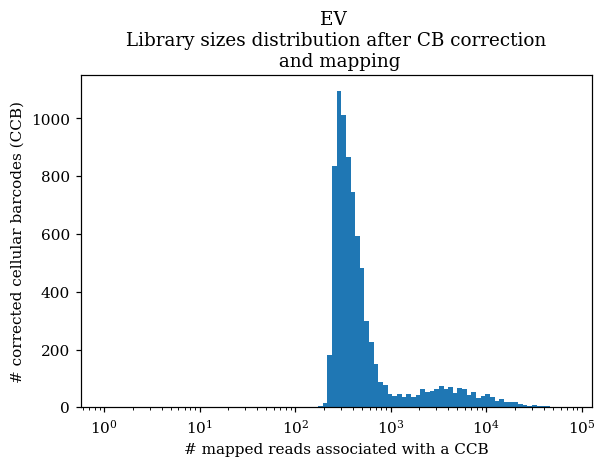

In [11]:
plt.title(f"{cell_line} \n Library sizes distribution after CB correction \n and mapping")
plt.xlabel("# mapped reads associated with a CCB")
plt.ylabel("# corrected cellular barcodes (CCB)")
RNAseq.plot_loghist(x["MappedReads"], bins=100)

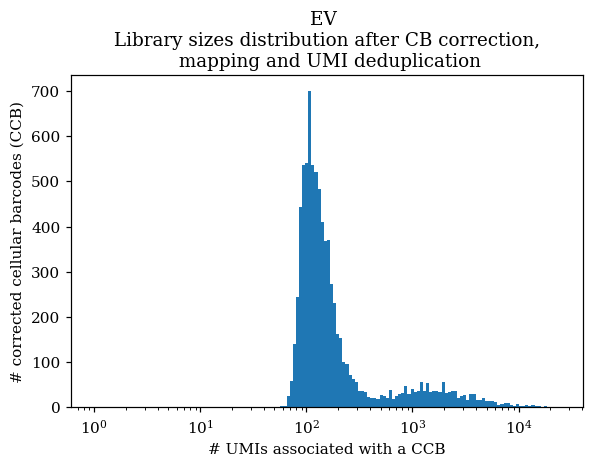

In [12]:
plt.title(f"{cell_line} \n Library sizes distribution after CB correction, \n mapping and UMI deduplication")
plt.xlabel("# UMIs associated with a CCB")
plt.ylabel("# corrected cellular barcodes (CCB)")
RNAseq.plot_loghist(x["DeduplicatedReads"], bins=150)

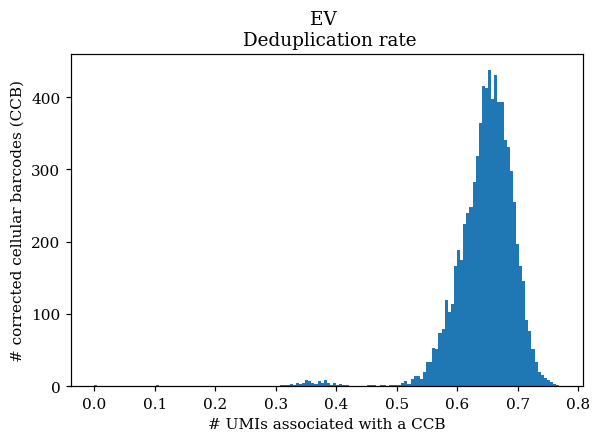

In [9]:
plt.title(f"{cell_line} \n Deduplication rate")
plt.xlabel("# UMIs associated with a CCB")
plt.ylabel("# corrected cellular barcodes (CCB)")
plt.hist(x["DedupRate"], bins=150);

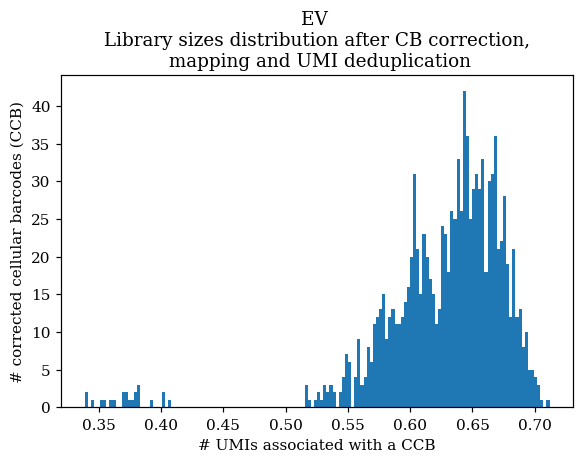

In [22]:
i = x["DeduplicatedReads"]>600
plt.title(f"{cell_line} \n Library sizes distribution after CB correction, \n mapping and UMI deduplication")
plt.xlabel("# UMIs associated with a CCB")
plt.ylabel("# corrected cellular barcodes (CCB)")
plt.hist(x["DedupRate"][i], bins=150);

In [24]:
(x["DedupRate"][i]<0.45).sum()

22

In [43]:
x

,CB,CorrectedReads,MappedReads,DeduplicatedReads,MappingRate,DedupRate,MeanByMax,NumGenesExpressed,NumGenesOverMean,ArborescenceCount
0,GCAGTAGCTTAT,52704,40834,14252,0.774780,0.650977,0.018566,4489,945,NaN
1,CGACGGTGAATC,53819,42625,13683,0.792007,0.678991,0.029820,4370,901,NaN
2,CGGCCGTCCCGC,51707,40626,14052,0.785696,0.654113,0.026402,4224,959,NaN
3,GGACAGTTAAAT,58202,45083,15029,0.774595,0.666637,0.018284,4592,1047,NaN
4,TTATCCAGCTAA,58704,44395,15423,0.756252,0.652596,0.021157,4703,971,NaN
...,...,...,...,...,...,...,...,...,...,...
7975,ATTCAAGTTGAT,332,239,78,0.719880,0.673640,0.475610,82,73,NaN
7976,CAGGATTTATTT,332,251,77,0.756024,0.693227,0.493590,78,72,NaN
7977,AATATGCAGACC,332,242,113,0.728916,0.533058,0.500000,113,4,NaN
7978,CGCGCTTCTGTT,332,255,81,0.768072,0.682353,0.500000,81,2,NaN


### Loading raw count matrix

In [25]:
sc = RNAseq.sc_Dataset(project_path = f"/home/arion/davidm/Data/datasets/private/RNA-seq/sc/{project}", samples_id = "condition", samples= [cell_line], quant_tool="alevin", quant_params = 'trimmed-reads-cutadapt/pc-decoys-k17-1.4.0/forceCells-7000-noWh', pp = "raw", cdna = "3' tag")
sc.save()

Annotating condition...
Annotating barcodes...
Annotating total_UMIs...
Annotating #_genes...


In [44]:
sc.annotate_samples(samples_annot_name="dedup", samples_annot=x["DedupRate"].values.astype(float))
sc.annotate_samples(samples_annot_name="nm", samples_annot=x["NumGenesOverMean"].values.astype(float))
sc.save()

dedup already annotated. Set ow = True if you want to overwrite.
Annotating nm...


In [184]:
sc.mtx.shape

(7980, 20305)

### Non stringent filtering

In [162]:
sc.reload()

__QC before filtering__

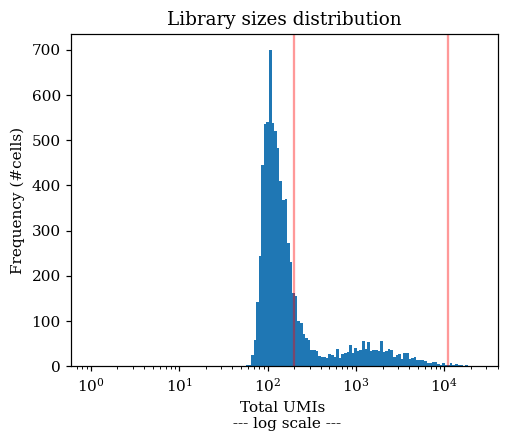

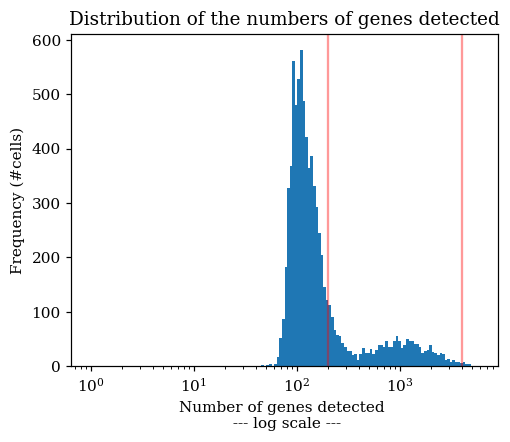

Annotating max_corr...


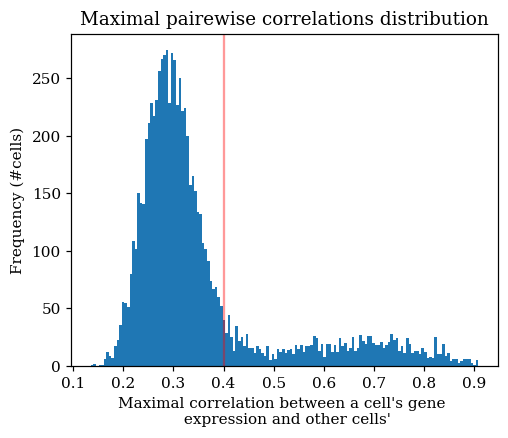

Annotating mt_frac...
Annotating chromosome_name using Biomart (Ensembl Genes 100, 'hsapiens_gene_ensembl')...


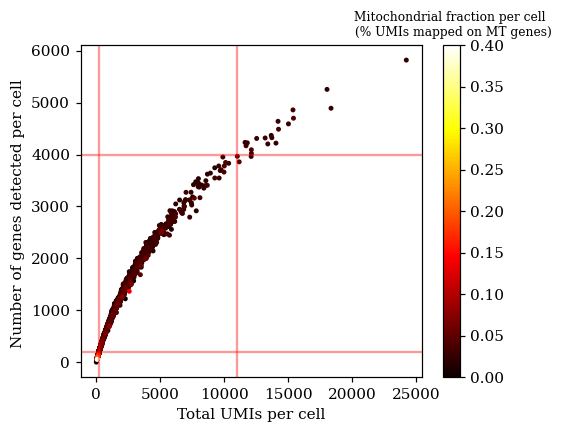

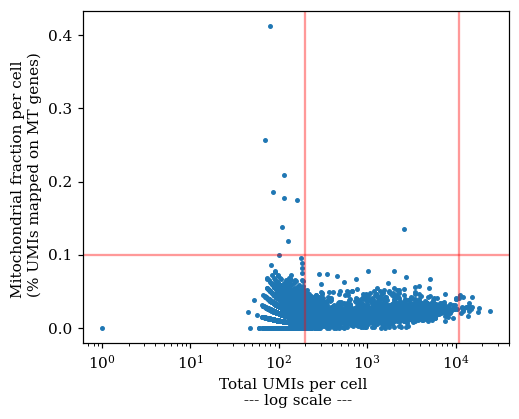

In [237]:
sc.plot_qc(n_counts_max=11000, n_counts_min = 200, n_genes_max=4000, n_genes_min = 200, mt_max = 0.1, max_corr_thr = 0.4, n_bins = 150)
sc.save()

/u/davidm/VirtualEns/python_3.6.8/lib64/python3.6/site-packages/numba/np/ufunc/parallel.py:355: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 6103. The TBB threading layer is disabled.
  warnings.warn(problem)


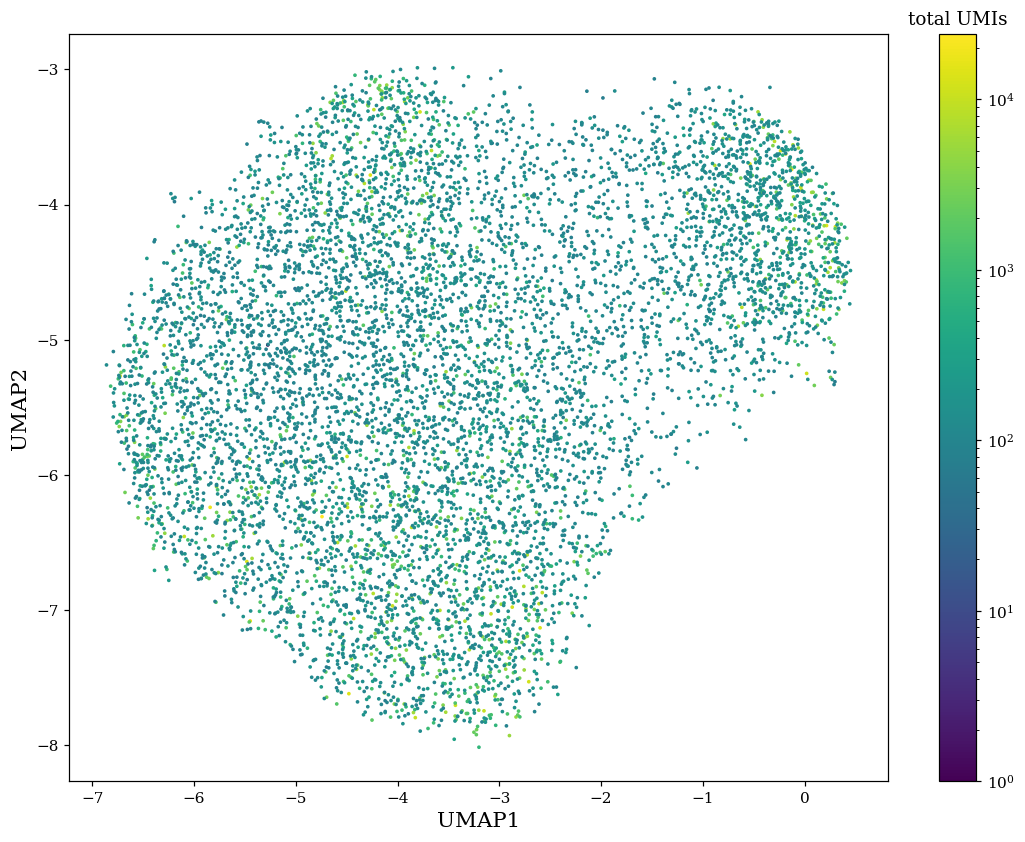

In [33]:
sc.lib_size_normalization(plot = False)
sc.dim_reduc(method = "pca", n_components = 50, plot = False)
sc.dim_reduc(method = "umap", layer = "pca", color_by = "total_UMIs", color_log_scale=True)

Annotating rp_frac...
Annotating external_gene_name using Biomart (Ensembl Genes 100, 'hsapiens_gene_ensembl')...
Already performed umap. To overwrite, set ow = True.


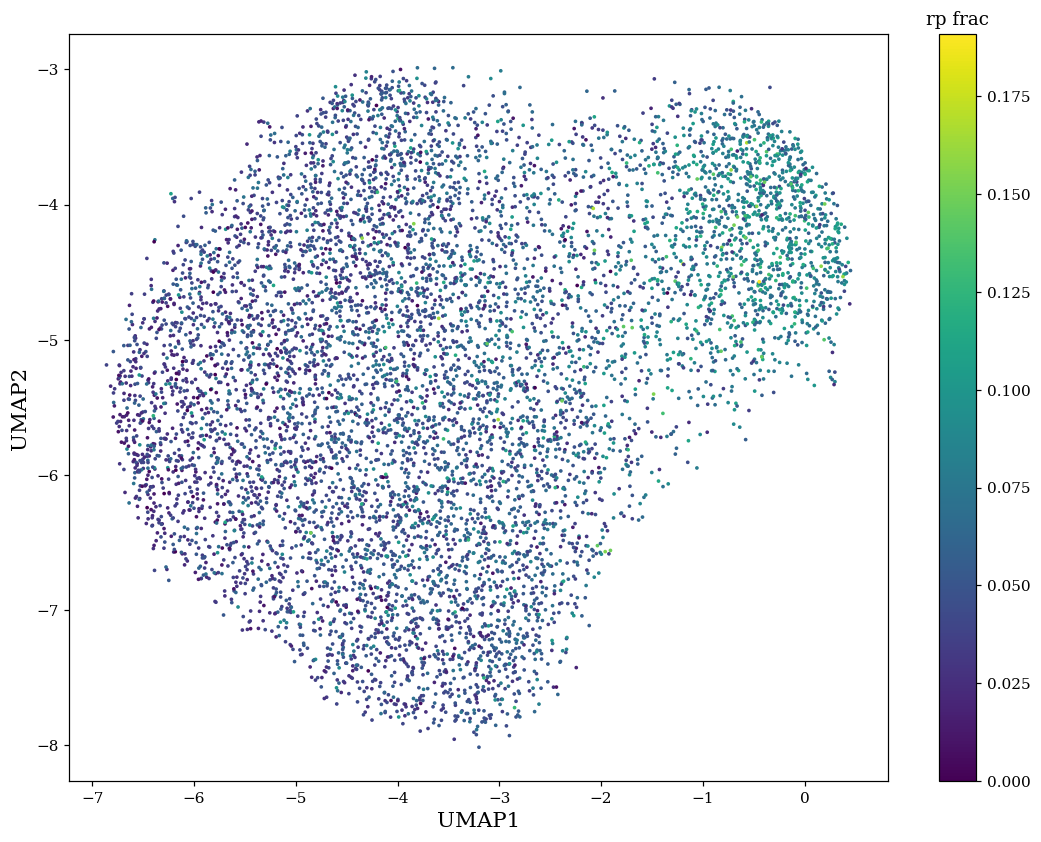

In [40]:
sc.annotate_samples("rp_frac")
sc.dim_reduc(method = "umap", layer = "pca", color_by = "rp_frac")

__Filtering cells__

In [169]:
sc.reload()
sc.filter_cells(n_counts_max=11000, n_counts_min = 200, n_genes_max=4000, n_genes_min = 200, mt_max = 0.1, max_corr_thr = 0.4);
sc_ns = sc.copy()
sc_ns.save()

In [170]:
sc_ns.mtx.shape

(1466, 20305)

__QC after filtering__

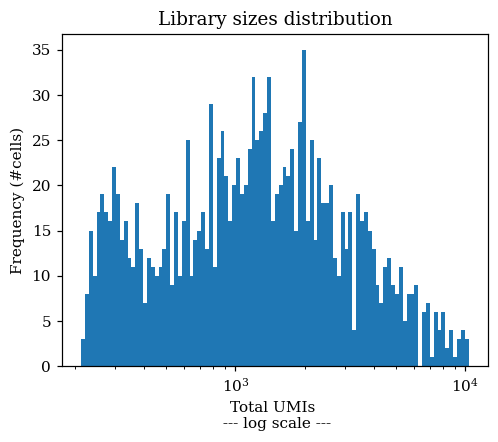

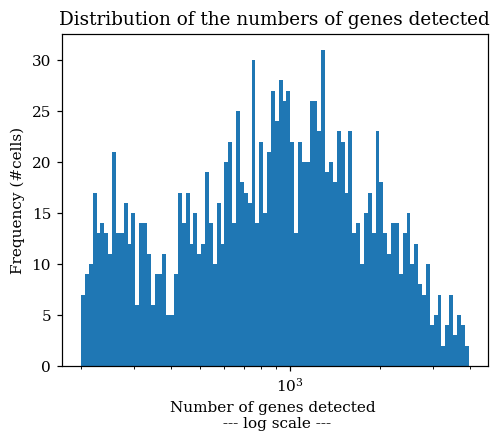

max_corr already annotated. Set ow = True if you want to overwrite.


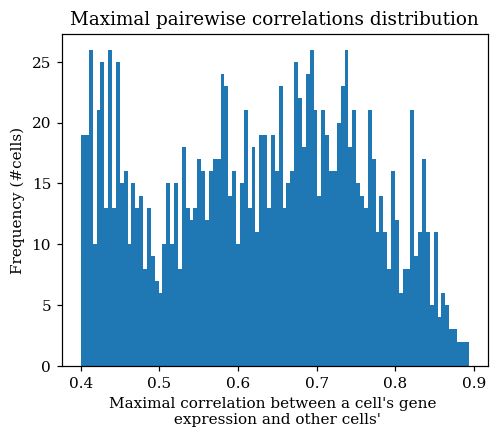

mt_frac already annotated. Set ow = True if you want to overwrite.


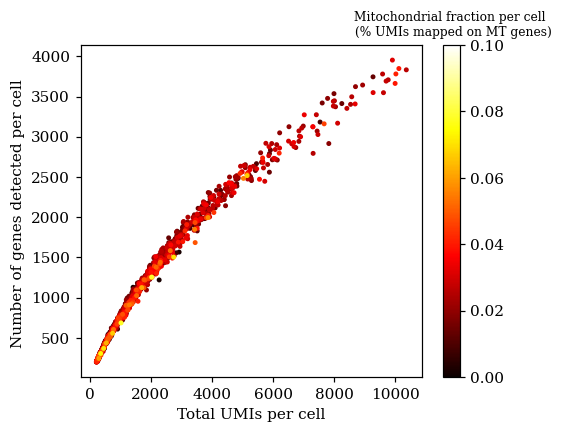

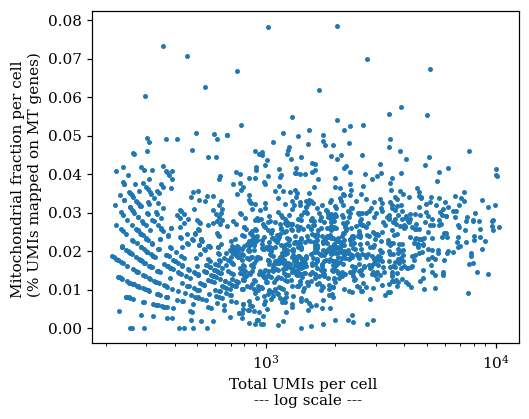

In [171]:
sc_ns.plot_qc(show_cutoffs=False)

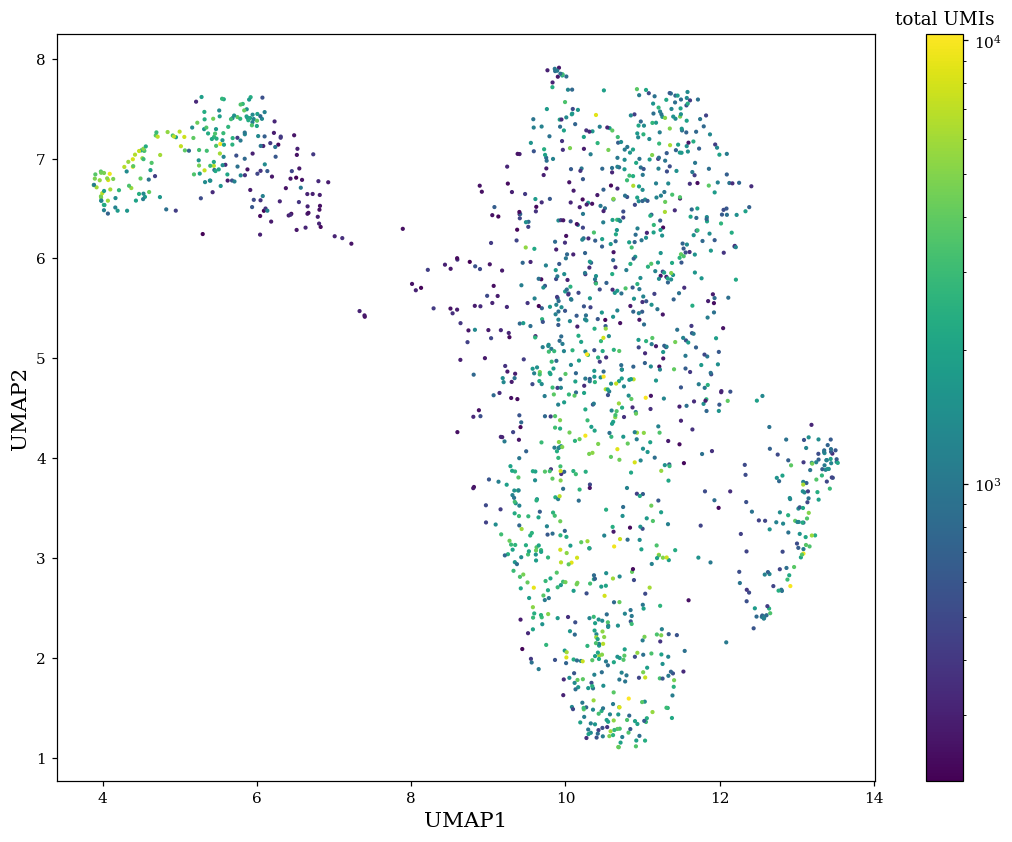

In [173]:
sc_ns.reload()
sc_ns.lib_size_normalization(plot = False)
sc_ns.pca(n_components = 50, plot = False)
sc_ns.umap(color_by = "total_UMIs", color_log_scale=True, )

### Stringent filtering

In [174]:
sc.reload()

__QC__

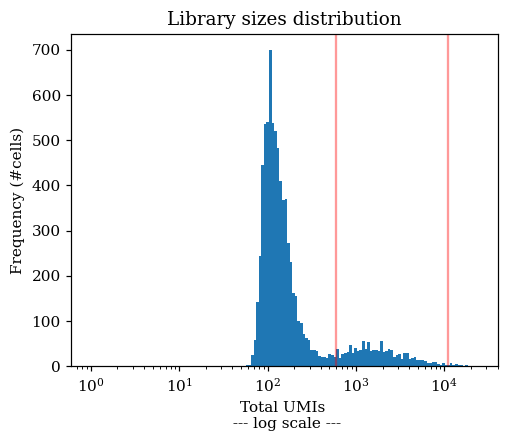

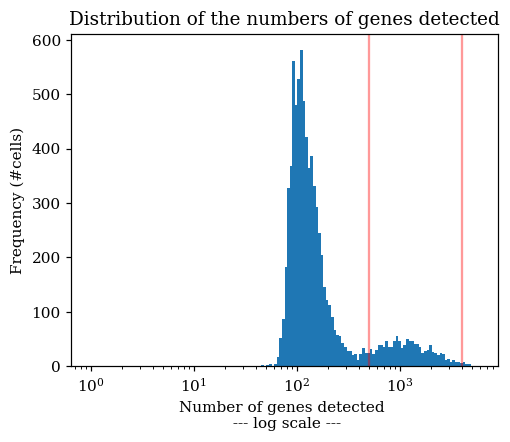

Annotating max_corr...
Dataset already log-normalized. To overwrite, set ow = True.


AttributeError: 'sc_Dataset' object has no attribute 'log_norm'

In [212]:
sc.plot_qc(n_counts_max=11000, n_counts_min = 600, n_genes_max=4000, n_genes_min = 500, mt_max = 0.05, max_corr_thr = 0.5, n_bins = 150)

__Filtering cells__

In [211]:
sc_s = sc.copy()
sc_s.filter_cells(n_counts_max=11000, n_counts_min = 600, n_genes_max=4000, n_genes_min = 500, mt_max = 0.05, max_corr_thr = 0.5);
sc_s.save()

In [177]:
sc_s.mtx.shape

(1060, 20305)

__QC after filtering__

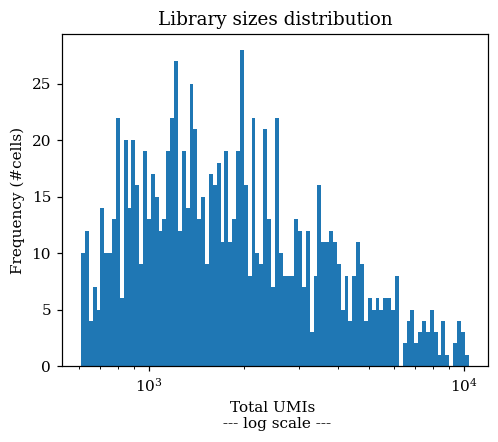

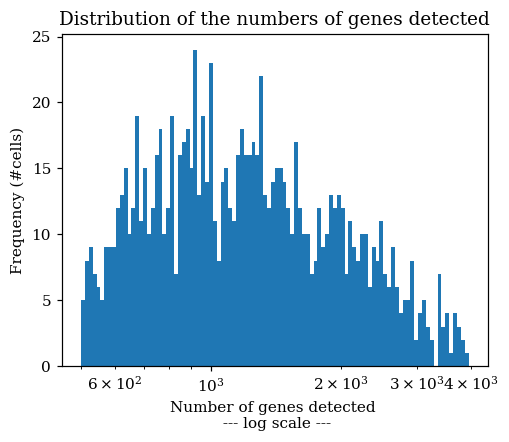

max_corr already annotated. Set ow = True if you want to overwrite.


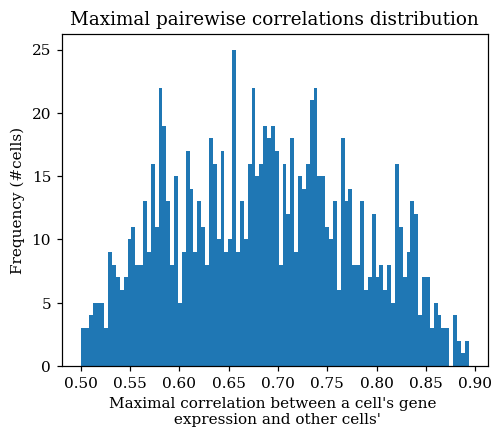

mt_frac already annotated. Set ow = True if you want to overwrite.


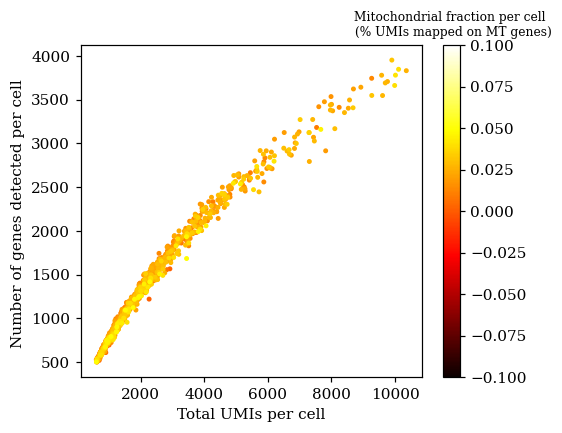

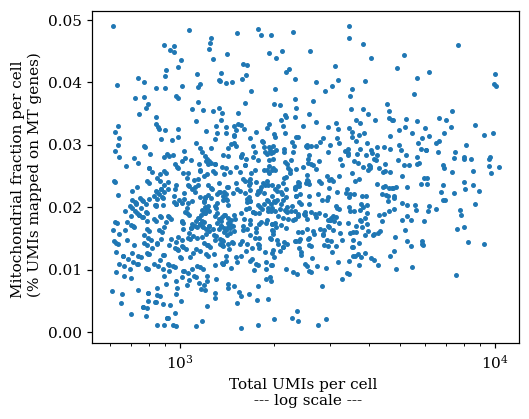

In [178]:
sc_s.plot_qc(show_cutoffs=False)

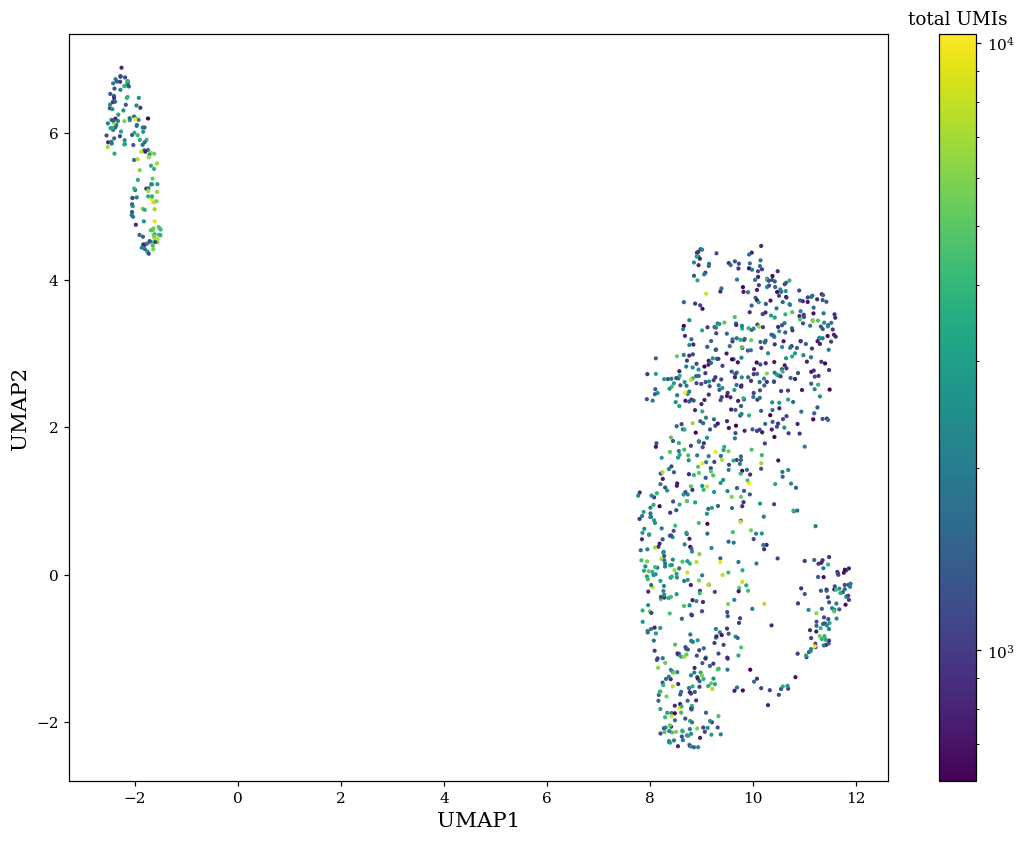

In [179]:
sc_s.lib_size_normalization(plot = False)
sc_s.pca(n_components = 50, plot = False)
sc_s.umap(color_by = "total_UMIs", color_log_scale=True, )

### Compare stringent & non stringent filtring

In [45]:
sc_ns.reload()
sc_ns.annotate_genes(genes_annot_name="external_gene_name")
sc_ns.annotate_samples(samples_annot_name="qc", samples_annot = np.array(["stringent" if b in sc_s.barcodes else "non-stringent" for b in sc_ns.barcodes], dtype = str), ow = True)
sc_ns.save()

Annotating external_gene_name using Biomart (Ensembl Genes 100, 'hsapiens_gene_ensembl')...
Annotating qc...


Annotating batch...
Annotating qc...
Annotating batch...
Annotating external_gene_name using Biomart (Ensembl Genes 100, 'hsapiens_gene_ensembl')...


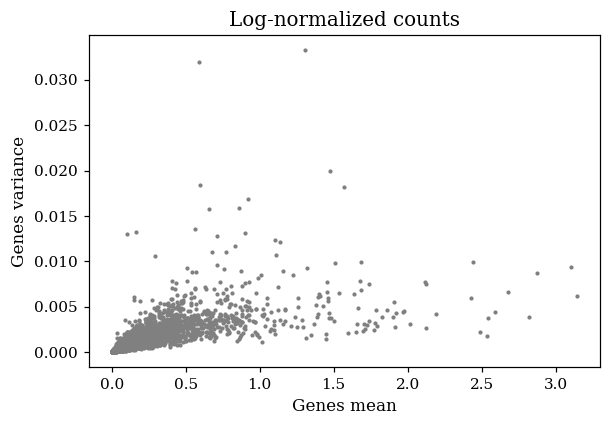

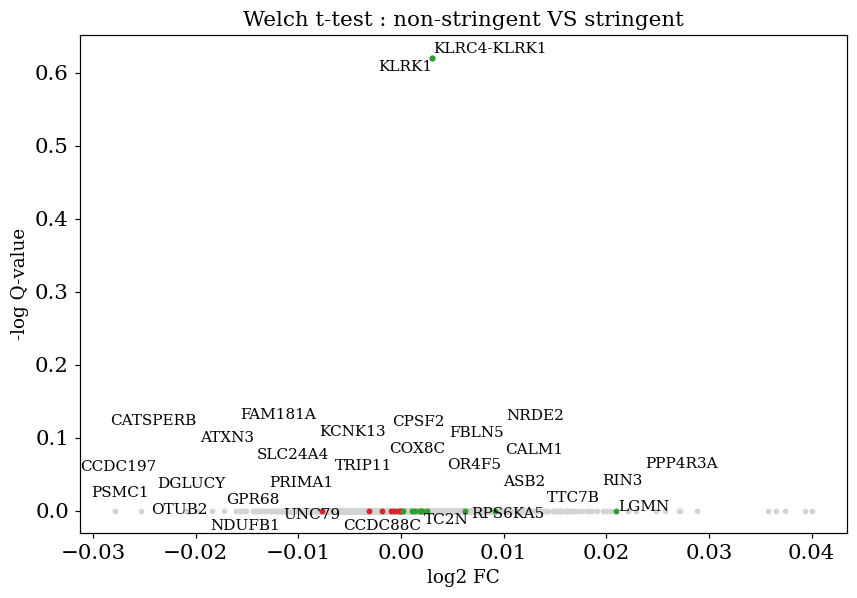

(array([ 3.0407910e-03,  3.0407910e-03,  0.0000000e+00, ...,
         0.0000000e+00, -6.7225774e-05,  2.8818607e-02], dtype=float32),
 array([1.17973563e-05, 1.17973563e-05, 1.00000000e+00, ...,
        1.00000000e+00, 9.39996944e-01, 2.02863161e-01]),
 array([0.23954532, 0.23954532, 1.        , ..., 1.        , 1.        ,
        1.        ]))

In [49]:
rep = 30
sc_ns.reload()
b = np.repeat(np.arange(0,rep).reshape(1, -1), len(sc_ns.mtx)//(rep-2), axis = 0).ravel()
b = b[:len(sc_ns.mtx)].astype(str)
np.random.shuffle(b)
sc_ns.annotate_samples(samples_annot_name="batch", samples_annot=b)
ps = sc_ns.pseudobulk(group_by_annot_name = ["qc", "batch"])

ps.annotate_genes(genes_annot_name = "external_gene_name")
ps.downsample(libs = 3000)

ps.save()

ps.lib_size_normalization(1e3)

ps.ttest(samples_annot_name="qc", samples_annot_ref="stringent", samples_annot_test="non-stringent", top = 30, qval_cutoff = 0.05)

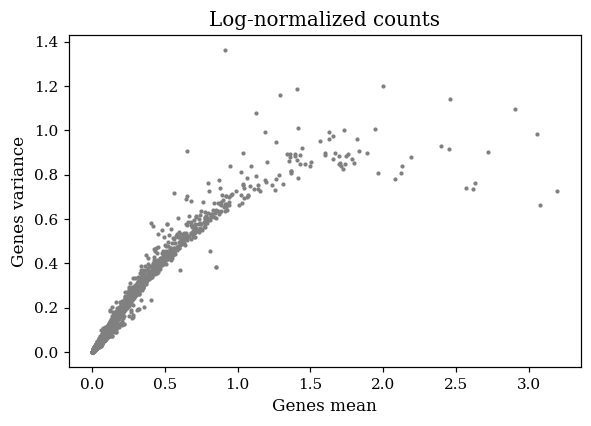

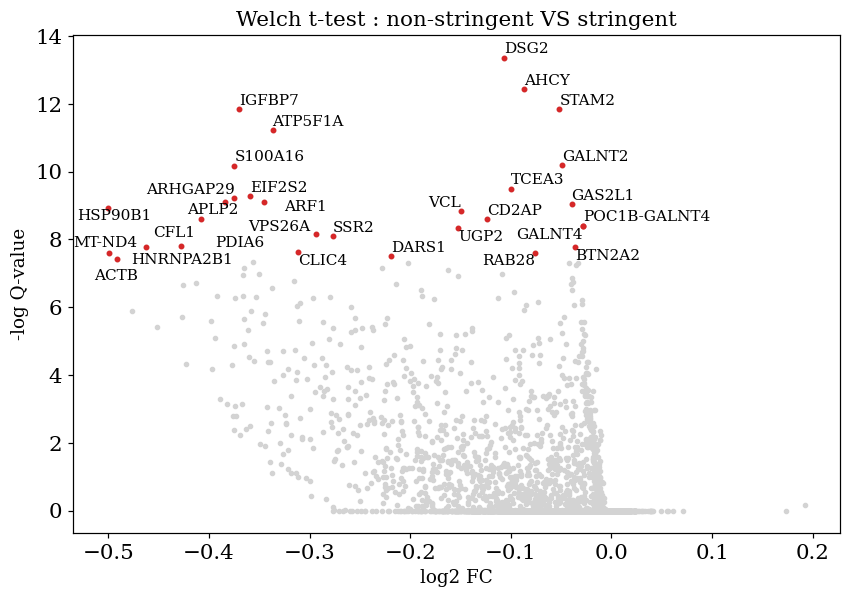

(array([-0.10672319, -0.08686379, -0.3697648 , ..., -0.06431232,
        -0.00717866, -0.00153839], dtype=float32),
 array([2.13048999e-18, 1.82481581e-17, 7.09850233e-17, ...,
        7.61490295e-04, 1.66709402e-03, 8.70090644e-02]),
 array([4.32595992e-14, 3.70528851e-13, 1.44135090e-12, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00]))

In [47]:
sc_ns.reload()
# sc_ns.downsample(libs = int(min(sc_ns.mtx.sum(1))))
sc_ns.lib_size_normalization()

sc_ns.ttest(samples_annot_name="qc", samples_annot_ref="stringent", samples_annot_test="non-stringent", top = 30, qval_cutoff = 0.05)

### Saving filtered count matrix

In [180]:
sc_s.save_files(pp="filtered")